In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号  

from scipy.optimize import curve_fit
# rng = np.random.default_rng()
import os
path='figs/' #创建图片文件
os.makedirs(path,exist_ok=True) 

# 规范化不确定度

In [28]:
def string_result(x,dx,latex=False):
    #返回类型位字符串，latex变量选择是否返回LaTeX源码
    order_x=np.floor(np.log10(abs(x)))
    order_dx=np.floor(np.log10(abs(dx)))
    value_x=x/10**order_x
    value_dx=dx/10**order_dx
    delord=order_x-order_dx
    # print(delord)
    if delord>=0:
        two_number=0
        # print(value_dx)
        if (value_dx<2):
            two_number=1
        
        value_dx=value_dx*10**(-delord)
        # order_x=log(x)/log(10)
        delord+=two_number
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"
    else :
        delord = abs(delord)
        value_x = value_x*10**(-delord)
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"

    if latex:
        return(f'$( {value_x_show}\\pm{value_dx_show} )\\times 10^{order_x}$')
    else:
        return(f'({value_x_show} ± {value_dx_show} )×10^{order_x}')

# $\mathrm{Al}$-屏蔽层靠近放射源

In [29]:
data_Al1 = pd.read_excel('Data.xlsx',sheet_name='Al1')
data_Al1

,Time(s),Background,mass density incresement,mass density,count,count margin,count error,count rate,count rate error
0,200.0,3341.0,0.000,0.000,169574,166233,407.716813,831.165,2.038584
1,NaN,NaN,2.035,2.035,144764,141423,376.062495,707.115,1.880312
2,NaN,NaN,2.043,4.078,122997,119656,345.913284,598.280,1.729566
3,NaN,NaN,2.051,6.129,105339,101998,319.371257,509.990,1.596856
4,NaN,NaN,2.043,8.172,89889,86548,294.190415,432.740,1.470952
5,NaN,NaN,2.029,10.201,76784,73443,271.003690,367.215,1.355018
6,NaN,NaN,2.051,12.252,66151,62810,250.619233,314.050,1.253096
7,NaN,NaN,2.051,14.303,48928,45587,213.511124,227.935,1.067556
8,NaN,NaN,1.975,16.278,41862,38521,196.267674,192.605,0.981338


## 直接带误差拟合

### 对计数率拟合

第0个参数的结果为:$( 8.49\pm0.18 )\times 10^2.0$
第1个参数的结果为:$( 8.6\pm0.3 )\times 10^-2.0$
决定系数R^2为:0.9991687332459581


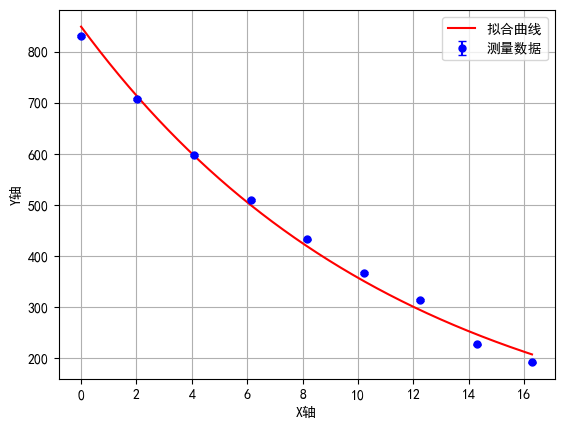

In [30]:
def my_model(x, N0, mu):
    return N0*np.exp(-mu*x)

# Your Data
x_data = data_Al1['mass density'].values
y_data = data_Al1['count rate'].values
y_error = data_Al1['count rate error'].values

# Now the curve_fit is done
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error,p0=(8600,0.08))

# Extract the parameter result
std = np.sqrt(np.diag(covmatrix))

# Rebulit the estimatied value
y_fit = my_model(x_data,*params )

y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)
rss = np.sum((y_data - y_fit)**2)
r_squared = 1 - (rss / tss)

# Reporting the result
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# Vituralize
plt.figure()
plt.errorbar(x_data, y_data, yerr=y_error, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
# plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))}f}")
plt.show()

### 对计数拟合

第0个参数的结果为:$( 1.73\pm0.03 )\times 10^5.0$
第1个参数的结果为:$( 8.3\pm0.2 )\times 10^-2.0$
决定系数R^2为:0.9993610400446904


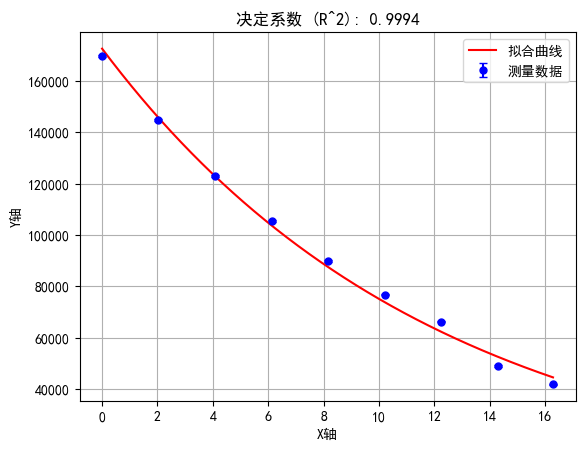

In [31]:
def my_model(x, N0, mu):
    return N0*np.exp(-mu*x)

# Your Data
x_data = data_Al1['mass density'].values
y_data = data_Al1['count'].values
y_error = data_Al1['count error'].values

# Now the curve_fit is done
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error,p0=(8600,0.08))

# Extract the parameter result
std = np.sqrt(np.diag(covmatrix))

# Rebulit the estimatied value
y_fit = my_model(x_data,*params )

y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)
rss = np.sum((y_data - y_fit)**2)
r_squared = 1 - (rss / tss)

# Reporting the result
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# Vituralize
plt.figure()
plt.errorbar(x_data, y_data, yerr=y_error, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))}f}")
plt.show()

## 对数后的带误差拟合

### 对计数率拟合

第0个参数的结果为:$( 6.79\pm0.04 )\times 10^0.0$
第1个参数的结果为:$( 9.2\pm0.4 )\times 10^-2.0$
决定系数R^2为:0.9998882316938797


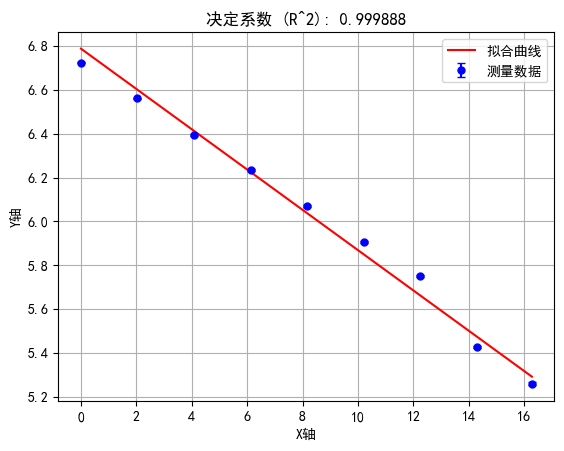

In [35]:
# 定义非线性模型
def my_model(x, ln_N0, mu):
    return ln_N0 - mu*x

# 创建模拟数据
# np.random.seed(0)
x_data = data_Al1['mass density'].values
y_data = np.log(data_Al1['count rate'].values)
y_error_weight = data_Al1['count rate error'].values
y_error_plot = y_error_weight/data_Al1['count rate'].values

# 使用curve_fit进行非线性拟合
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error_weight,p0=(67,0.09))

# 提取拟合参数

std = np.sqrt(np.diag(covmatrix))

# 计算拟合值
y_fit = my_model(x_data,*params )

# 计算总平方和（Total Sum of Squares，TSS）
y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)

# 计算残差平方和（Residual Sum of Squares，RSS）
rss = np.sum((y_data - y_fit)**2)

# 计算决定系数 R^2
r_squared = 1 - (rss / tss)

# 结果报道
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# 可视化拟合过程
plt.figure()
# plt.scatter(x_data, y_data, label='原始数据', color='b')
plt.errorbar(x_data, y_data, yerr=y_error_plot, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

#如果是np可接受的函数会方便很多，这里考虑一般情况
linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))+2}f}")
plt.show()

# params,std,r_squared

### 对计数拟合

第0个参数的结果为:$( 1.209\pm0.004 )\times 10^1.0$
第1个参数的结果为:$( 9.2\pm0.4 )\times 10^-2.0$
决定系数R^2为:0.9969798587842444


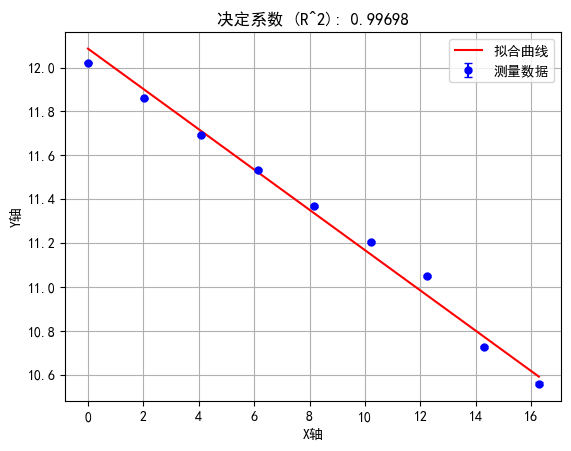

In [38]:
# 定义非线性模型
def my_model(x, ln_N0, mu):
    return ln_N0 - mu*x

# 创建模拟数据
# np.random.seed(0)
x_data = data_Al1['mass density'].values
y_data = np.log(data_Al1['count margin'].values)
y_error_weight = data_Al1['count error'].values
y_error_plot = y_error_weight/data_Al1['count margin'].values

# 使用curve_fit进行非线性拟合
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error_weight,p0=(67,0.09))

# 提取拟合参数

std = np.sqrt(np.diag(covmatrix))

# 计算拟合值
y_fit = my_model(x_data,*params )

# 计算总平方和（Total Sum of Squares，TSS）
y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)

# 计算残差平方和（Residual Sum of Squares，RSS）
rss = np.sum((y_data - y_fit)**2)

# 计算决定系数 R^2
r_squared = 1 - (rss / tss)

# 结果报道
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# 可视化拟合过程
plt.figure()
# plt.scatter(x_data, y_data, label='原始数据', color='b')
plt.errorbar(x_data, y_data, yerr=y_error_plot, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

#如果是np可接受的函数会方便很多，这里考虑一般情况
linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))+2}f}")
plt.show()

# params,std,r_squared

# $\mathrm{Al}$-屏蔽层靠近探测器

In [45]:
data_Al2 = pd.read_excel('Data.xlsx',sheet_name='Al2')
data_Al2 = data_Al2.drop(9)
data_Al2

,Time(s),Background,mass density incresement,mass density,count,count margin,count error,count rate,count rate error
0,200.0,3341.0,0.000,0.000,169574,166233,407.716813,831.165,2.038584
1,NaN,NaN,2.035,2.035,145679,142338,377.277087,711.690,1.886385
2,NaN,NaN,2.043,4.078,125088,121747,348.922628,608.735,1.744613
3,NaN,NaN,2.051,6.129,110330,106989,327.091730,534.945,1.635459
4,NaN,NaN,2.043,8.172,95759,92418,304.003289,462.090,1.520016
5,NaN,NaN,2.029,10.201,82236,78895,280.882538,394.475,1.404413
6,NaN,NaN,2.051,12.252,71228,67887,260.551339,339.435,1.302757
7,NaN,NaN,2.051,14.303,60638,57297,239.367918,286.485,1.196840
8,NaN,NaN,1.975,16.278,53949,50608,224.962219,253.040,1.124811


第0个参数的结果为:$( 1.659\pm0.008 )\times 10^5.0$
第1个参数的结果为:$( 7.31\pm0.06 )\times 10^-2.0$
决定系数R^2为:0.9999415639208511


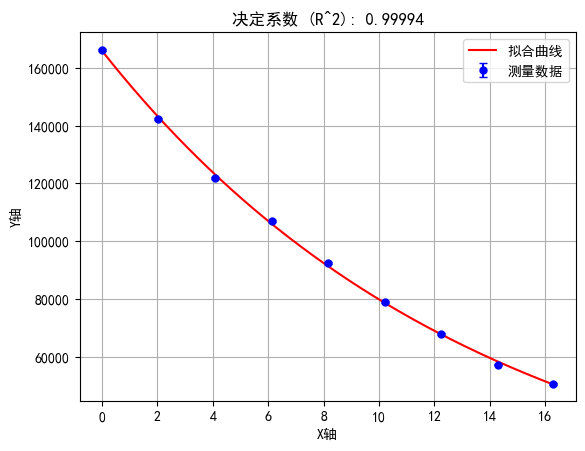

In [46]:
# 定义非线性模型
def my_model(x, N0, mu):
    return N0*np.exp(-mu*x)

# 创建模拟数据
# np.random.seed(0)
x_data = data_Al2['mass density'].values
y_data = data_Al2['count margin'].values
y_error = data_Al2['count error'].values

# 使用curve_fit进行非线性拟合
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error,p0=(8600,0.08))

# 提取拟合参数

std = np.sqrt(np.diag(covmatrix))

# 计算拟合值
y_fit = my_model(x_data,*params )

# 计算总平方和（Total Sum of Squares，TSS）
y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)

# 计算残差平方和（Residual Sum of Squares，RSS）
rss = np.sum((y_data - y_fit)**2)

# 计算决定系数 R^2
r_squared = 1 - (rss / tss)

# 结果报道
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# 可视化拟合过程
plt.figure()
plt.errorbar(x_data, y_data, yerr=y_error, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

#如果是np可接受的函数会方便很多，这里考虑一般情况
linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))}f}")
plt.show()


# params,std,r_squared

第0个参数的结果为:$( 1.2021\pm0.0008 )\times 10^1.0$
第1个参数的结果为:$( 7.34\pm0.07 )\times 10^-2.0$
决定系数R^2为:0.999955860308839


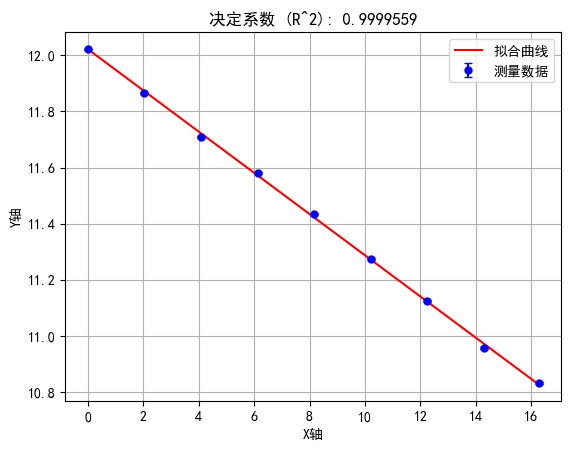

In [47]:
# 定义非线性模型
def my_model(x, ln_N0, mu):
    return ln_N0 - mu*x

# 创建模拟数据
# np.random.seed(0)
# x_data = mass_thick
# y_data = np.log(count_rate)
# y_error_weight = count_error
# y_error_plot = y_error_weight/y_data
x_data = data_Al2['mass density'].values
y_data = np.log(data_Al2['count margin'].values)
y_error_weight = data_Al2['count error'].values
y_error_plot = y_error_weight/data_Al2['count margin'].values

# 使用curve_fit进行非线性拟合
params, covmatrix = curve_fit(my_model, x_data, y_data,sigma=y_error_weight,p0=(67,0.08))

# 提取拟合参数

std = np.sqrt(np.diag(covmatrix))

# 计算拟合值
y_fit = my_model(x_data,*params )

# 计算总平方和（Total Sum of Squares，TSS）
y_mean = np.average(x_data,weights=1/y_error**2)
tss = np.sum((y_data - y_mean)**2)

# 计算残差平方和（Residual Sum of Squares，RSS）
rss = np.sum((y_data - y_fit)**2)

# 计算决定系数 R^2
r_squared = 1 - (rss / tss)

# 结果报道
for i in range(params.shape[0]):
    print(f'第{i}个参数的结果为:{string_result(params[i],std[i],latex=True)}')

print(f"决定系数R^2为:{r_squared}")



# 可视化拟合过程
plt.figure()
# plt.scatter(x_data, y_data, label='原始数据', color='b')
plt.errorbar(x_data, y_data, yerr=y_error_plot, fmt='bo', markersize=5, capsize=3, capthick=1, label='测量数据')

max_value = np.max(x_data)
min_value = np.min(x_data)
linspace_xdata = np.linspace(min_value, max_value, 1000)

#如果是np可接受的函数会方便很多，这里考虑一般情况
linspace_ydata=[]
for v in linspace_xdata:
    linspace_ydata.append(my_model(v,*params))

linspace_ydata=np.array(linspace_ydata)

plt.plot(linspace_xdata, linspace_ydata, label='拟合曲线', color='r')
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.legend()
plt.grid()
plt.title(f"决定系数 (R^2): {r_squared:.{int(1-np.log10(1-r_squared))+2}f}")
plt.show()

# params,std,r_squared